In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

In [3]:
# Parameter
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

# Text conditioning
TEXT_EMB_DIM = 512        # CLIP ViT-B/32 text embedding size
MAX_TOKENS = 77
USE_TEXT_CONDITION = True
TEXT_PROJECTION_DIM = 128   # projection before injecting into U-Net

# Attention U-Net
USE_ATTENTION_GATES = True
ATTN_CHANNEL_RATIO = 0.5    # controls size of intermediate channels in attention blocks

In [4]:
# Load data
train_data= utils.image_dataset_from_directory(
    "/kaggle/input/flowers-dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 2746 files belonging to 5 classes.


I0000 00:00:1763219099.990824      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763219099.991471      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
def cosine_diffusion_schedulers(diffusion_times):
    signal_rates= tf.cos(diffusion_times * math.pi/2)
    noise_rates= tf.sin(diffusion_times * math.pi/2)
    return noise_rates, signal_rates

In [8]:
def offset_cosine_diffusion_schedulers(diffusion_times):
    min_signal_rate= 0.02
    max_signal_rate= 0.95
    start_angle= tf.acos(max_signal_rate)
    end_angle= tf.acos(min_signal_rate)

    diffusion_angle= start_angle+diffusion_times * (end_angle- start_angle)
    signal_rate= tf.cos(diffusion_angle)
    noise_rate= tf.sin(diffusion_angle)

    return noise_rate, signal_rate

In [9]:
def sinusoidal_embedding(t):
    """
    t: Tensor with shape (B,1,1,1) or (B,1). Values in [0,1] (diffusion time / noise variance scalar).
    Returns: Tensor shape (B, 1, 1, NOISE_EMBEDDING_SIZE)
    
    Formula (per pos-enc style):
      emb[2i]   = sin(t * freq_i)
      emb[2i+1] = cos(t * freq_i)
    where freq_i = exp(-i * log(10000)/ (D/2) )
    """
    # ensure shape (B, 1)
    t_flat = tf.reshape(t, [-1, 1])  # (B,1)

    half = NOISE_EMBEDDING_SIZE // 2
    # frequencies (increasing)
    inv_freq = tf.exp(-tf.cast(tf.range(half, dtype=tf.float32) * (math.log(10000.0) / half), tf.float32))
    # angles: (B, half) = (B,1) * (half,)
    angles = t_flat * inv_freq[None, :]
    emb = tf.concat([tf.sin(angles), tf.cos(angles)], axis=-1)  # (B, NOISE_EMBEDDING_SIZE)
    emb = tf.reshape(emb, [-1, 1, 1, NOISE_EMBEDDING_SIZE])     # (B,1,1,D)
    return emb

In [10]:
def text_conditioned_attn_gate(x, g, t, inter_channels):

    # 1) Linear projections
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, use_bias=False)(x)
    phi_g   = layers.Conv2D(inter_channels, kernel_size=1, use_bias=False)(g)

    # 2) Resize gating signal
    phi_g = layers.Resizing(
        height=x.shape[1],
        width=x.shape[2],
        interpolation="bilinear"
    )(phi_g)

    # 3) Text projection
    t_proj = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1))(t)
    t_proj = layers.Dense(inter_channels, activation="relu")(t_proj)
    t_proj = layers.Reshape((1, 1, inter_channels))(t_proj)

    # Broadcast text (using Keras ops)
    t_proj = layers.UpSampling2D(
        size=(x.shape[1], x.shape[2]),
        interpolation="nearest"
    )(t_proj)

    # 4) Combine signals
    attn = layers.Add()([theta_x, phi_g, t_proj])
    attn = layers.ReLU()(attn)

    # Make mask match skip channels
    attn = layers.Conv2D(x.shape[-1], kernel_size=1, activation="sigmoid")(attn)

    # 5) Apply attention
    out = layers.Multiply()([x, attn])

    return out

In [11]:
class TextConditionedAttnGate(layers.Layer):
    def __init__(self, inter_channels):
        super().__init__()
        self.inter_channels = inter_channels
        self.theta_conv = layers.Conv2D(inter_channels, 1, use_bias=False)
        self.phi_conv = layers.Conv2D(inter_channels, 1, use_bias=False)
        self.t_dense = layers.Dense(inter_channels, activation="relu")
        self.attn_conv = layers.Conv2D(1, 1, activation="sigmoid")

    def call(self, x, g, t):
        theta_x = self.theta_conv(x)
        phi_g = self.phi_conv(g)
        phi_g = tf.image.resize(phi_g, tf.shape(theta_x)[1:3])
        t_proj = tf.reduce_mean(t, axis=1)
        t_proj = self.t_dense(t_proj)
        t_proj = tf.reshape(t_proj, (-1, 1, 1, self.inter_channels))
        t_proj = tf.tile(t_proj, [1, tf.shape(theta_x)[1], tf.shape(theta_x)[2], 1])
        attn = tf.nn.relu(theta_x + phi_g + t_proj)
        # Create single-channel attention mask, then tile to match x channels
        attn = self.attn_conv(attn)  # (B, H, W, 1)
        x_channels = tf.shape(x)[-1]
        attn = tf.tile(attn, [1, 1, 1, x_channels])  # (B, H, W, x_channels)
        return x * attn

In [43]:
x = tf.keras.Input((16,16,64))
g = tf.keras.Input((8,8,64))
t = tf.keras.Input((77,512))
y = text_conditioned_attn_gate(x,g,t,inter_channels=48)
model = tf.keras.Model([x,g,t], y)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 77, 512)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 512)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 8, 8, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 48)        │     24,624 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 16, 16,    │      3,072 │ input_layer[0][0] │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 8, 8, 48)  │      3,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 48)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 16, 16,    │          0 │ conv2d_49[0][0],  │
│                     │ 48)               │            │ conv2d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, None,      │          0 │ reshape_3[0][0],  │
│                     │ None, 48)         │            │ conv2d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, None,      │          0 │ conv2d_48[0][0],  │
│                     │ None, 48)         │            │ lambda_15[0][0],  │
│                     │                   │            │ lambda_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ add_17[0][0]      │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, None,      │         49 │ activation_3[0][… │
│                     │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, None,      │          0 │ input_layer[0][0… │
│ (Multiply)          │ None, 64)         │            │ conv2d_50[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,817 (120.38 KB)

 Trainable params: 30,817 (120.38 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def Residual_block(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [13]:
def Up_block(width, block_depth):
    def apply(inputs):
        x, skips, t_emb = inputs
        skip = skips.pop()

        # 1) Upsample decoder path
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)

        # 2) Resize x to match skip (Keras-safe version)
        x = layers.Resizing(
            height=skip.shape[1],
            width=skip.shape[2],
            interpolation="bilinear"
        )(x)

        # 3) Text-conditioned attention on skip
        attn_skip = TextConditionedAttnGate(width // 2)(skip, x, t_emb)

        # 4) Merge with skip
        x = layers.Concatenate()([x, attn_skip])

        # 5) Apply residual stack
        for _ in range(block_depth):
            x = Residual_block(width)(x)

        return x
    return apply

In [14]:
def Down_block(width, block_depth):
    def apply(x):
        x, skips=x
        for _ in range(block_depth):
            x=Residual_block(width)(x)
            skips.append(x)
        x=layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply

In [15]:
def build_text_conditioned_unet(IMAGE_SIZE, NOISE_EMBEDDING_SIZE, max_tokens=MAX_TOKENS, text_emb_dim=TEXT_EMB_DIM):
    """
    Returns:
      unet_model: Keras Model([noisy_images, noise_variances, text_embeddings], predicted_noise)
    Notes:
      - text_embeddings shape: (B, seq_len, text_emb_dim)
      - noise_variances shape: (B, 1, 1, 1) or (B, 1)
    """
    # Inputs
    noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="noisy_images")
    noise_variances = layers.Input(shape=(1, 1, 1), name="noise_variances")
    text_embeddings = layers.Input(shape=(max_tokens, text_emb_dim), name="text_embeddings")

    # Initial conv
    x = layers.Conv2D(32, kernel_size=1, padding="same")(noisy_images)

    # Sinusoidal embedding -> (B,1,1,NOISE_EMBEDDING_SIZE)
    noise_emb = layers.Lambda(sinusoidal_embedding, output_shape=(1,1,NOISE_EMBEDDING_SIZE))(noise_variances)

    # Expand to full spatial size
    noise_emb_spatial = layers.Lambda(lambda z: tf.tile(z, [1, IMAGE_SIZE, IMAGE_SIZE, 1]))(noise_emb)

    # Concatenate with initial conv features
    x = layers.Concatenate()([x, noise_emb_spatial])

    # Prepare skip list
    skips = []

    # Encoder (Down)
    x = Down_block(32, block_depth=2)([x, skips])
    x = Down_block(64, block_depth=2)([x, skips])
    x = Down_block(96, block_depth=2)([x, skips])

    # Bottleneck
    x = Residual_block(128)(x)
    x = Residual_block(128)(x)

    # Decoder (Up) 
    x = Up_block(96, block_depth=2)([x, skips, text_embeddings])
    x = Up_block(64, block_depth=2)([x, skips, text_embeddings])
    x = Up_block(32, block_depth=2)([x, skips, text_embeddings])
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x) 
    
    # Output conv (predict noise)
    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros", padding="same")(x)

    model = models.Model([noisy_images, noise_variances, text_embeddings], x, name="text_conditioned_attention_unet")
    return model

In [16]:
unet = build_text_conditioned_unet(IMAGE_SIZE, NOISE_EMBEDDING_SIZE, max_tokens=MAX_TOKENS, text_emb_dim=TEXT_EMB_DIM)

In [17]:
unet.summary()

Model: "text_conditioned_attention_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_variances     │ (None, 1, 1, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noisy_images        │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 32)  │          0 │ noise_variances[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        128 │ noisy_images[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 64,    │          0 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 64)               │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,464 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ average_pooling2… │
│ (BatchNormalizatio… │ 32)               │            │                 

 Total params: 1,894,374 (7.23 MB)

 Trainable params: 1,891,750 (7.22 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [ ]:
class Diffusion_model(models.Model):
    def __init__(self, unet, image_size, noise_emb_size, ema_decay=0.999):
        """
        text-conditioned diffusion wrapper.
        Args:
          - unet: Keras Model that accepts [noisy_images, noise_variances, text_embeddings]
          - image_size: spatial size H=W
          - noise_emb_size: dimension returned by sinusoidal_embedding
          - ema_decay: EMA decay factor (EMA)
        """
        super().__init__()
        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_decay = ema_decay
        self.diffusion_schedule = offset_cosine_diffusion_schedulers
        self.image_size = image_size
        self.noise_emb_size = noise_emb_size

        
        noisy_images_ema = layers.Input(shape=(image_size, image_size, 3), name="noisy_images_ema")
        noise_variances_ema = layers.Input(shape=(1, 1, 1), name="noise_variances_ema")
        text_emb_shape = unet.input_shape[2][1:]  # Skip batch dimension
        text_embeddings_ema = layers.Input(shape=text_emb_shape, name="text_embeddings_ema")  # (B, seq_len, text_dim)
        x_ema_out = self.network([noisy_images_ema, noise_variances_ema, text_embeddings_ema])
        self.ema_network = models.Model([noisy_images_ema, noise_variances_ema, text_embeddings_ema],
                                        x_ema_out, name="unet_ema")

    def call(self, inputs, training=False):
        noisy_img, noise_variance, text_embeddings = inputs
    
        noisy_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
        noise_variance = tf.convert_to_tensor(noise_variance, dtype=tf.float32)
        text_embeddings = tf.convert_to_tensor(text_embeddings, dtype=tf.float32)
    
        noise_rate, signal_rate = self.diffusion_schedule(noise_variance)
    
        pred_noise, pred_img = self.denoise(
            noisy_img, noise_rate, signal_rate, text_embeddings, training=training
        )
        return pred_img


    def denoise(self, noisy_img, noise_rate, signal_rate, text_embeddings, training):
        """Forward pass through UNet or EMA network with shape-safe tensors."""
        network = self.network if training else self.ema_network
    
        while len(noise_rate.shape) < len(noisy_img.shape):
            noise_rate = tf.expand_dims(noise_rate, -1)
    
        if len(text_embeddings.shape) == 2:
            # Missing batch dimension - add it
            text_embeddings = tf.expand_dims(text_embeddings, axis=0)
        
        expected_shape = tf.shape(noisy_img)[0]  # batch size
        tf.debugging.assert_equal(
            tf.shape(text_embeddings)[0], 
            expected_shape,
            message="Batch size mismatch between images and text embeddings"
        )

        pred_noise = network([noisy_img, tf.square(noise_rate), text_embeddings], training=training)
    
        pred_img = (noisy_img - noise_rate * pred_noise) / signal_rate
        return pred_noise, pred_img

    def compile(self, optimizer, loss_fn, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.loss = loss_fn
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, img):
        imgs = self.normalizer.mean + img * tf.sqrt(self.normalizer.variance)
        return tf.clip_by_value(imgs, 0.0, 1.0)

    def reverse_diffusion(self, initial_noise, diffusion_steps, text_embeddings):
        """
        Run reverse diffusion conditioned on text_embeddings.
        Inputs:
          - initial_noise: tensor (N,H,W,3)
          - diffusion_steps: int
          - text_embeddings: (N, seq_len, text_dim)
        """
        num_img = tf.shape(initial_noise)[0]
        step_size = 1.0 / float(diffusion_steps)
        current_img = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_img, 1, 1, 1), dtype=current_img.dtype) - step * step_size
            noise_rate, signal_rate = self.diffusion_schedule(diffusion_times)
            pred_noise, pred_img = self.denoise(current_img, noise_rate, signal_rate, text_embeddings, training=False)

            next_diffusion_time = diffusion_times - step_size
            next_noise_rate, next_signal_rate = self.diffusion_schedule(next_diffusion_time)

            # update current image using predicted denoised image and predicted noise
            current_img = next_signal_rate * pred_img + next_noise_rate * pred_noise

        return pred_img

    def generate(self, num_images, diffusion_steps, text_embeddings, initial_noise=None):
        """
        Public sampling method. Provide text_embeddings (shape: [num_images, seq_len, text_dim]).
        """
        if initial_noise is None:
            initial_noise = tf.random.normal(shape=(num_images, self.image_size, self.image_size, 3))
        generated_img = self.reverse_diffusion(initial_noise, diffusion_steps, text_embeddings)
        generated_img = self.denormalize(generated_img)
        return generated_img

    def train_step(self, data):
        """
        Training expects `data` to be a tuple (images, text_embeddings):
          - images: (BATCH_SIZE, H, W, 3)
          - text_embeddings: (BATCH_SIZE, seq_len, text_dim)

        We'll:
         - normalize images
         - sample diffusion timestep per example
         - compute noisy images
         - predict noise and compute loss
         - apply gradients
         - update EMA
        """
        images, text_embeddings = data

        images = self.normalizer(images, training=True)

        batch = tf.shape(images)[0]
        noise = tf.random.normal(shape=(batch, self.image_size, self.image_size, 3))
        diffusion_time = tf.random.uniform(shape=(batch, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rate, signal_rate = self.diffusion_schedule(diffusion_time)
        noisy_images = signal_rate * images + noise_rate * noise

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(noisy_images, noise_rate, signal_rate, text_embeddings, training=True)
            loss_value = self.loss(noise, pred_noises)

        grads = tape.gradient(loss_value, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(loss_value)

        # EMA update: ema_w = decay * ema_w + (1 - decay) * w
        for w, ema_w in zip(self.network.weights, self.ema_network.weights):
            ema_w.assign(self.ema_decay * ema_w + (1.0 - self.ema_decay) * w)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, text_embeddings = data
        images = self.normalizer(images, training=False)
        batch = tf.shape(images)[0]
        noises = tf.random.normal(shape=(batch, self.image_size, self.image_size, 3))
        diffusion_times = tf.random.uniform(shape=(batch, 1, 1, 1), minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, text_embeddings, training=False)
        loss_value = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(loss_value)
        return {m.name: m.result() for m in self.metrics}

In [19]:
ddm = Diffusion_model(
    unet=unet,
    image_size=IMAGE_SIZE,
    noise_emb_size=NOISE_EMBEDDING_SIZE
)

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import TFCLIPTextModel, AutoTokenizer

# Load tokenizer & model 
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32", from_pt=True)

flower_labels = tf.constant(["daisy", "dandelion", "rose", "sunflower", "tulip"])

# Image-only preprocessing for normalizer
def preprocess_img_only(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Create image-only dataset for normalizer adapt
image_only_dataset = train_data.map(preprocess_img_only, num_parallel_calls=tf.data.AUTOTUNE)
image_only_dataset = image_only_dataset.batch(BATCH_SIZE, drop_remainder=True)
image_only_dataset = image_only_dataset.prefetch(tf.data.AUTOTUNE)

# Normalizer adapt
ddm.normalizer.adapt(image_only_dataset)


# Pre-compute text embeddings for all images (avoids batch size 1 issues) 
all_images = []
all_labels = []
all_text_embs = []

# Collect all data
for img, label in train_data:
    all_images.append(img.numpy())
    all_labels.append(label.numpy())

# Generate text for all labels
all_texts = []
flower_names_list = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
for label in all_labels:
    flower_name = flower_names_list[label]
    text = f"a photo of a {flower_name}"
    all_texts.append(text)

# Compute text embeddings in batches (avoids batch size 1 issue)
text_embeddings_list = []
BATCH_SIZE_TEXT = 32  # Process text embeddings in batches
for i in range(0, len(all_texts), BATCH_SIZE_TEXT):
    batch_texts = all_texts[i:i+BATCH_SIZE_TEXT]
    tokens = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=77, return_tensors="tf")
    outputs = text_encoder(tokens["input_ids"])
    batch_embs = outputs.last_hidden_state.numpy().astype("float32")
    text_embeddings_list.append(batch_embs)

# Concatenate all embeddings
all_text_embs = np.concatenate(text_embeddings_list, axis=0)

# Create dataset from pre-computed data
def create_dataset_from_arrays(images, labels, text_embs):
    """Create tf.data.Dataset from pre-computed arrays"""
    def gen():
        for img, label, text_emb in zip(images, labels, text_embs):
            yield img, text_emb
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(77, 512), dtype=tf.float32)
        )
    )

# Convert images to float32 and normalize
all_images = np.array(all_images, dtype=np.float32) / 255.0

# Create dataset
train = create_dataset_from_arrays(all_images, all_labels, all_text_embs)
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(tf.data.AUTOTUNE)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPTextModel: ['vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encode

In [20]:
train = train.map(lambda img, text_emb: (ddm.normalizer(img), text_emb),
                  num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
if LOAD_MODEL:
    ddm.built=True
    ddm.load_weights()

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "text_diffusion_checkpoint.keras",
    monitor="n_loss",
    save_best_only=True,
)

In [23]:
flower_labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
prompts = [f"a photo of a {flower}" for flower in flower_labels]

tokens = tokenizer(
    prompts,
    padding="max_length",
    truncation=True,
    max_length=77,
    return_tensors="tf"
)

text_embeddings = text_encoder(tokens["input_ids"]).last_hidden_state

In [24]:
class ImageGenerator(tf.keras.callbacks.Callback):
    def __init__(self, num_img, text_encoder, tokenizer, prompts, save_dir="./gen_output"):
        super().__init__()
        self.num_img = num_img
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.prompts = prompts
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        tokens = self.tokenizer(
            self.prompts,
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="tf"
        )
        text_embeddings = self.text_encoder(tokens["input_ids"]).last_hidden_state
        
        # If your model expects numpy arrays, convert:
        # text_embeddings = text_embeddings.numpy()
        
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=50,
            text_embeddings=text_embeddings
        )
        
        for i, img in enumerate(generated_images):
            img_path = os.path.join(self.save_dir, f"epoch{epoch+1}_img{i}.png")
            # Ensure img is in correct format [0-255] uint8 or [0-1] float
            tf.keras.preprocessing.image.save_img(img_path, img)

In [25]:
image_generator_callback = ImageGenerator(
    num_img=len(prompts),
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    prompts=prompts,
    save_dir="./gen_output"
)

In [26]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        epsilon=1e-8
    ),
     loss_fn=losses.MeanAbsoluteError(name="L1_loss"),
)

In [31]:
tf.config.optimizer.set_jit(False)

In [27]:
his = ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        image_generator_callback,
    ],
)

Epoch 1/50


I0000 00:00:1763219275.178067     114 service.cc:148] XLA service 0x52ac8460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763219275.178951     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763219275.178969     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1763219276.118928     114 assert_op.cc:38] Ignoring Assert operator assert_equal_1/Assert/Assert
I0000 00:00:1763219277.319707     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 37s 37s/step - n_loss: 0.7984

I0000 00:00:1763219296.703023     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    214/Unknown 61s 114ms/step - n_loss: 0.7374

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


214/214 ━━━━━━━━━━━━━━━━━━━━ 68s 148ms/step - n_loss: 0.7373
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - n_loss: 0.7128
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.7057
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - n_loss: 0.7025
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.7007
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6974
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6943
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6930
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6923
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6910
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6904
Epoch 12/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6900
Epoch 13/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - n_loss: 0.6892
Epoch 14/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - n_loss: 0.689

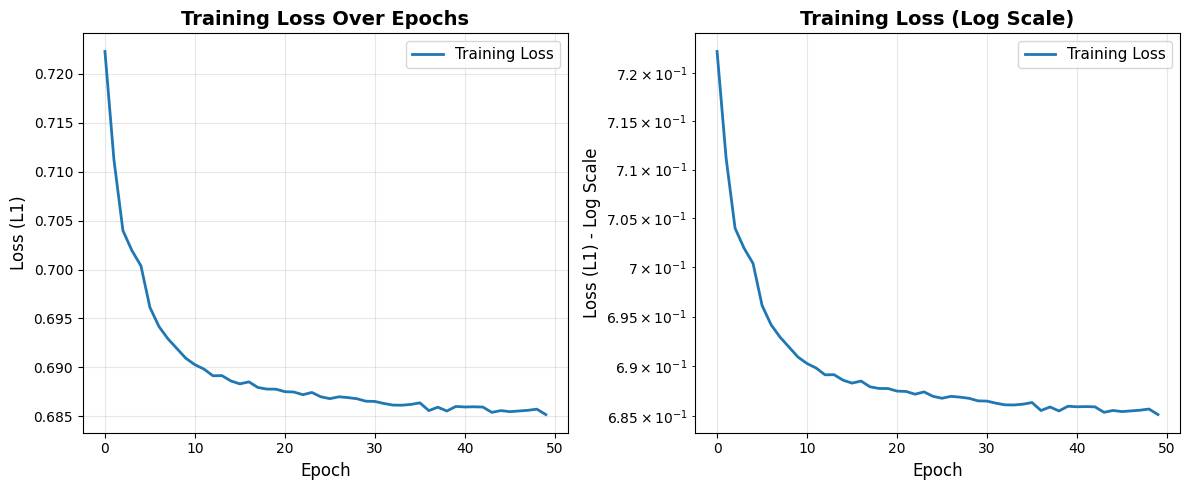

Final training loss: 0.685171


In [ ]:
# Plot training history
if 'his' in locals() and hasattr(his, 'history'):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(his.history['n_loss'], label='Training Loss', linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (L1)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Plot loss with log scale 
    plt.subplot(1, 2, 2)
    plt.plot(his.history['n_loss'], label='Training Loss', linewidth=2)
    plt.yscale('log')
    plt.title('Training Loss (Log Scale)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (L1) - Log Scale', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final loss
    final_loss = his.history['n_loss'][-1]
    print(f"Final training loss: {final_loss:.6f}")
else:
    print("Training history not available. Please run training first.")

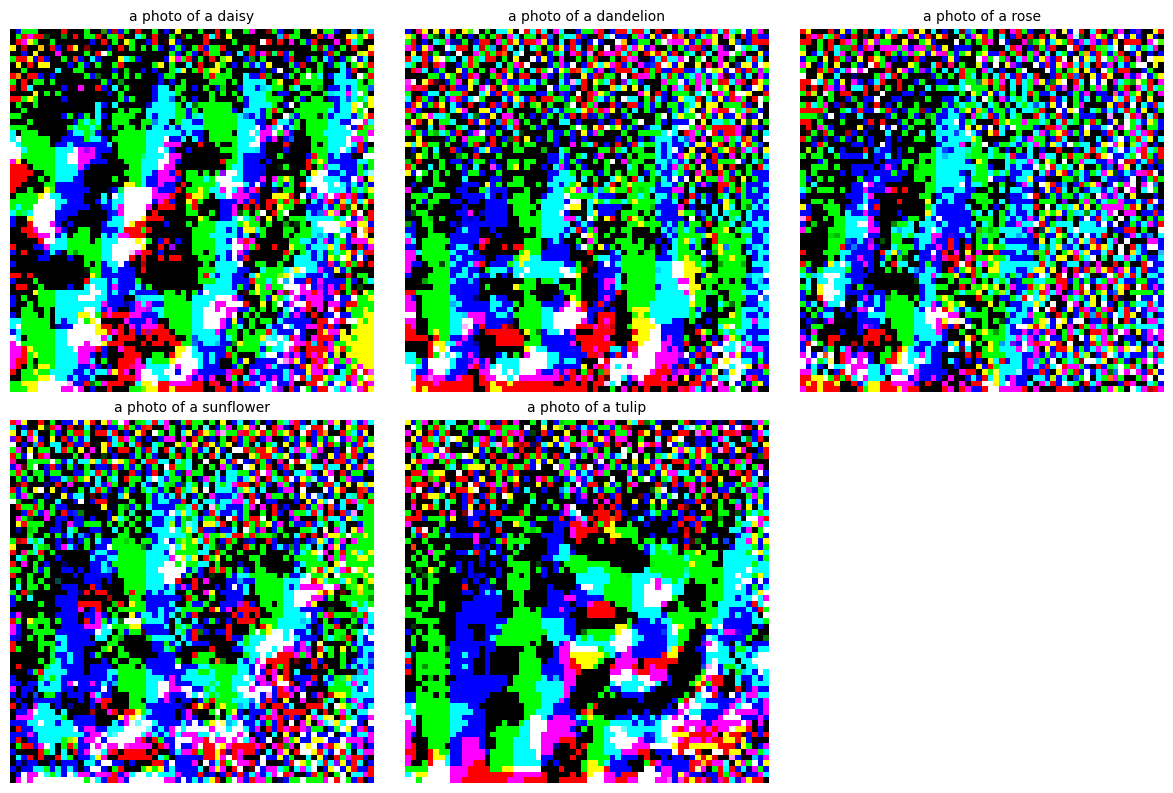

In [29]:
# Inference: Generate images from text prompts
def generate_images_from_prompts(model, tokenizer, text_encoder, prompts, diffusion_steps=50, save_dir="./inference_output"):
    """
    Generate images from text prompts using the trained diffusion model.
    
    Args:
        model: Trained Diffusion_model instance
        tokenizer: CLIP tokenizer
        text_encoder: CLIP text encoder
        prompts: List of text prompts
        diffusion_steps: Number of diffusion steps for generation
        save_dir: Directory to save generated images
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Tokenize and encode prompts
    tokens = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="tf"
    )
    text_embeddings = text_encoder(tokens["input_ids"]).last_hidden_state
    
    # Generate images
    num_images = len(prompts)
    generated_images = model.generate(
        num_images=num_images,
        diffusion_steps=diffusion_steps,
        text_embeddings=text_embeddings
    )
    
    # Convert to numpy and ensure proper format
    generated_images = generated_images.numpy()
    
    # Plot and save images
    n_images = len(prompts)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols
    
    plt.figure(figsize=(4 * cols, 4 * rows))
    
    for i in range(n_images):
        plt.subplot(rows, cols, i + 1)
        
        # Ensure image is in [0, 1] range
        img = generated_images[i]
        img = np.clip(img, 0.0, 1.0)
        
        plt.imshow(img)
        plt.title(prompts[i], fontsize=10, wrap=True)
        plt.axis('off')
        
        # Save individual image
        img_path = os.path.join(save_dir, f"generated_{i}_{prompts[i].replace(' ', '_')[:20]}.png")
        tf.keras.preprocessing.image.save_img(img_path, img)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "all_generated_images.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    return generated_images

# Test with flower prompts
test_prompts = [
    "a photo of a daisy",
    "a photo of a dandelion", 
    "a photo of a rose",
    "a photo of a sunflower",
    "a photo of a tulip"
]

# Generate images
generated_imgs = generate_images_from_prompts(
    ddm, 
    tokenizer, 
    text_encoder, 
    test_prompts, 
    diffusion_steps=50,
    save_dir="./inference_output"
)

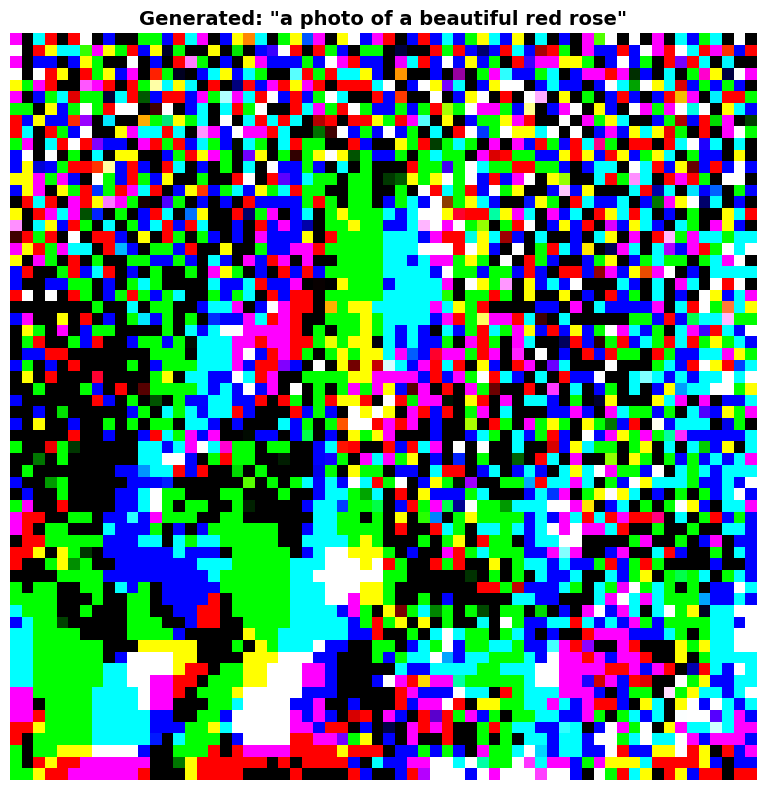

In [30]:
# Interactive inference: Generate from custom prompts
def generate_custom_image(model, tokenizer, text_encoder, prompt, diffusion_steps=50, seed=None):
    """
    Generate a single image from a custom text prompt.
    
    Args:
        model: Trained Diffusion_model instance
        tokenizer: CLIP tokenizer
        text_encoder: CLIP text encoder
        prompt: Text prompt string
        diffusion_steps: Number of diffusion steps
        seed: Random seed for reproducibility
    """
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)
    
    # Tokenize and encode prompt
    tokens = tokenizer(
        [prompt],
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="tf"
    )
    text_embeddings = text_encoder(tokens["input_ids"]).last_hidden_state
    
    # Generate image
    generated_image = model.generate(
        num_images=1,
        diffusion_steps=diffusion_steps,
        text_embeddings=text_embeddings
    )
    
    # Convert and display
    img = generated_image[0].numpy()
    img = np.clip(img, 0.0, 1.0)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Generated: "{prompt}"', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return img

# Example: Generate from custom prompt
custom_prompt = "a photo of a beautiful red rose"
custom_img = generate_custom_image(
    ddm, 
    tokenizer, 
    text_encoder, 
    custom_prompt, 
    diffusion_steps=50,
    seed=42
)

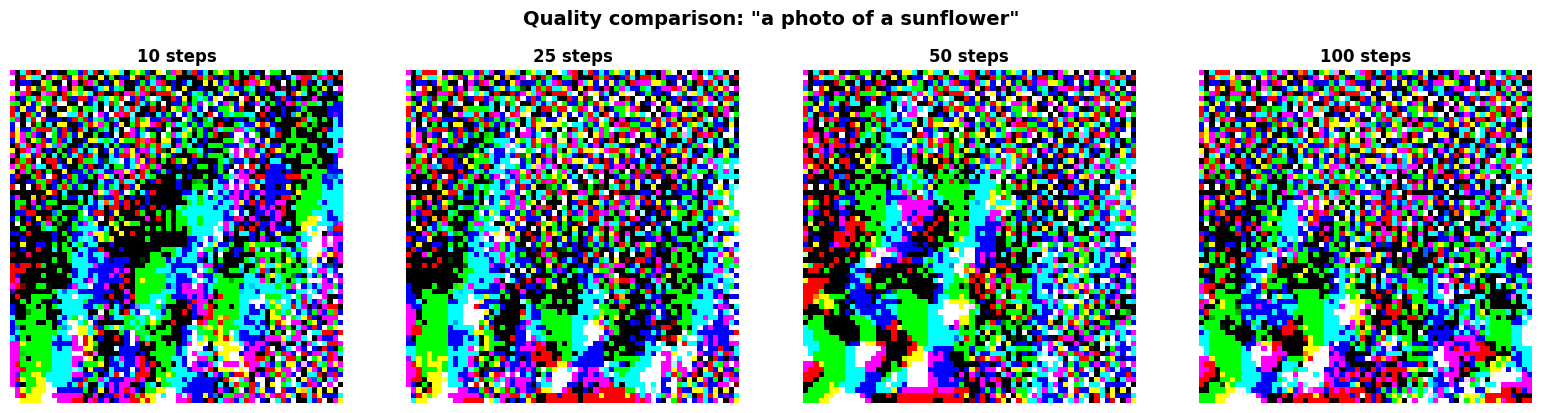

In [31]:
# Compare generated images at different diffusion steps
def compare_diffusion_steps(model, tokenizer, text_encoder, prompt, steps_list=[10, 25, 50, 100]):
    """
    Generate images with different numbers of diffusion steps to compare quality.
    
    Args:
        model: Trained Diffusion_model instance
        tokenizer: CLIP tokenizer
        text_encoder: CLIP text encoder
        prompt: Text prompt
        steps_list: List of diffusion step counts to test
    """
    # Tokenize and encode prompt
    tokens = tokenizer(
        [prompt],
        padding="max_length",
        truncation=True,
        max_length=77,
        return_tensors="tf"
    )
    text_embeddings = text_encoder(tokens["input_ids"]).last_hidden_state
    
    n_steps = len(steps_list)
    plt.figure(figsize=(4 * n_steps, 4))
    
    for idx, steps in enumerate(steps_list):
        # Set seed for fair comparison
        tf.random.set_seed(42)
        
        generated_image = model.generate(
            num_images=1,
            diffusion_steps=steps,
            text_embeddings=text_embeddings
        )
    
        img = generated_image[0].numpy()
        img = np.clip(img, 0.0, 1.0)
        
        plt.subplot(1, n_steps, idx + 1)
        plt.imshow(img)
        plt.title(f'{steps} steps', fontsize=12, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(f'Quality comparison: "{prompt}"', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('diffusion_steps_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Compare different step counts
test_prompt = "a photo of a sunflower"
compare_diffusion_steps(ddm, tokenizer, text_encoder, test_prompt, steps_list=[10, 25, 50, 100])